In [1]:
# Set up
%pylab
%pylab inline
%matplotlib inline
%load_ext autoreload
%autoreload 2
import tqdm
import random
import pandas as pd
from sklearn import datasets
import sklearn
import seaborn as sns
from PIL import Image
import scipy
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib


In [3]:
class K_MEANS:
    '''
    Divides given data into K clusters.
    
    Fields:
        df: Dataset without 'target' attribute
        N: Size of dataset
        k: Number of clusters
        MAX_ITER: Number of iterations
        labels: Class of each sample
        centroids: N x 2 array with coordinates of centroids
        distances: N x N matrix of distances, where len(df) = N
    '''
    
    def __init__(self, data, k = 3, MAX_ITER = 100):
        self.df = np.array(data)
        (self.N, self.M) = self.df.shape
        self.k = k;
        self.MAX_ITER = MAX_ITER
        self.iterations = 0
        self.labels = np.zeros(self.N, dtype=np.int)
        self.centroids = self.random_centroids()
        self.distances = self.compute_distances()
       
        
    def random_centroids(self):
        '''
        Returns:
            List of random k indices
        '''
        centrs = random.sample(range(self.N), self.k)
        return self.df[centrs]
    
    
    def compute_distances(self):
        '''
        Returns: 
            N x N matrix of distances
        '''
        X, Y = self.df, self.centroids
        dists = -2 * np.dot(X, Y.T) + np.sum(Y ** 2, axis=1)
        return dists
        
    
    def assign_centroids(self):
        '''
        Find closest centroid for each data sample
        
        Returns:
            True: Found new centroids
            False: Centroids are the same
        '''
        self.distances = self.compute_distances()
        nearest_centroids = np.argmin(self.distances, axis=1)
        
        if abs(np.sum(nearest_centroids - self.labels)) < 1e-100:
            return False
        
        self.labels = nearest_centroids
        return True
    
    
    def update_centroids(self):
        '''
        Determine new centroids by taking the average of all the points 
        assigned to that cluster.
        '''
        new_centroids = np.zeros(self.k * self.M).reshape(self.k, self.M)
        centroid_cnt = np.full(self.k, 1e-100)
        for i in range(self.k):
            assigned_to_ith = self.labels == i
            new_centroids[i] += np.sum(self.df[assigned_to_ith], axis=0)
            centroid_cnt[i] += len(self.df[assigned_to_ith])
            
        self.centroids = new_centroids / centroid_cnt[:, np.newaxis]
        
    
    def RUN(self, show_images=False):
        '''
        Runs KMEANS algorithms as long as we can update centroids or till we reach MAX_ITER
        
        Parameters:
            show_images: True / False - either shows or does not show images
                         For a integer 'i' shows every ith image 
        '''
        for no in tqdm.tqdm(range(self.MAX_ITER), desc='K_MEANS', position=0, leave=True):
            self.iterations = no
            if not self.assign_centroids():
                if show_images:
                    self.plot_2d()
                break
            
            if show_images and no % show_images == 0:
                self.plot_2d()
                
            self.update_centroids()
    
    def plot_2d(self):
        plt.figure(dpi=100)
        plt.title(f'Iterations: {self.iterations}')
        plt.scatter(self.df[:, 0], self.df[:, 1], c=self.labels, edgecolor='black',
                    s=20, alpha=1)
        plt.scatter(self.centroids[:, 0], self.centroids[:, 1], c=range(self.k), 
                    edgecolor='red', s=100, alpha=0.8)
        plt.show()
        
        
    def plot_before_and_after_2d(self, X, Y):
        '''
        Parameters::
            X: [x_min, x_max]
            Y: [y_min, y_max]
        '''
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(20,5)
        ax1.scatter(self.df[:, 0], self.df[:, 1], c='white', edgecolor='black', s=20, alpha=0.5)
        ax2.scatter(self.df[:, 0], self.df[:, 1], c=self.labels, edgecolor='black', s=20, alpha=1)
        ax2.scatter(self.centroids[:, 0], self.centroids[:, 1], c=range(self.k),
                    edgecolor='red', s=100, alpha=0.8)
        ax1.set_xlim(X)
        ax1.set_ylim(Y)
        ax2.set_xlim(X)
        ax2.set_ylim(Y)
        
        
    def plot_before_and_after_3d(self):
        fig = plt.figure(figsize=(20, 8))
        # 121 - 1 x 2 grid 1st subplot
        ax1 = fig.add_subplot(121, projection='3d')
        ax2 = fig.add_subplot(122, projection='3d')
        ax1.scatter(self.df[:, 0], self.df[:, 1], self.df[:, 2], c='white', edgecolor='black', 
                    s=20, alpha=0.5)
        ax2.scatter(self.df[:, 0], self.df[:, 1], self.df[:, 2], c=self.labels, edgecolor='black',
                    s=20, alpha=1)
        ax2.scatter(self.centroids[:, 0], self.centroids[:, 1], self.centroids[:, 2],  
                    c=range(self.k), edgecolor='red', s=100, alpha=0.8)
    

In [7]:
def compress_image_RGB(img, colors=3):
    '''
    Compress image given in RGB.
    '''
    img_arr = np.array(img)
    X = img_arr.reshape(-1, img_arr.shape[-1])
    
    KM = K_MEANS(X, k=colors, MAX_ITER=100)
    KM.RUN(show_images=False)
    
    final_colors = img_arr.reshape(-1, img_arr.shape[-1])
    grouping = KM.labels
    centroid_colors = KM.centroids.reshape(KM.k, img_arr.shape[-1])

    for i in range(KM.k):
        final_colors[grouping == i] = centroid_colors[i]

    final_colors = final_colors.reshape(img_arr.shape)
    im = Image.fromarray(final_colors, 'RGB')
    
    return im


def show_images(img, colors=3):
    '''
    Show image before and after compression.
    '''
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
    compressed_image = compress_image_RGB(img, colors)
    ax1.imshow(img)
    ax1.set_title('Original Image')
    ax2.imshow(compressed_image)
    ax2.set_title(f'Image compressed with {colors} colors')

K_MEANS:  66%|██████▌   | 66/100 [00:12<00:06,  5.52it/s]

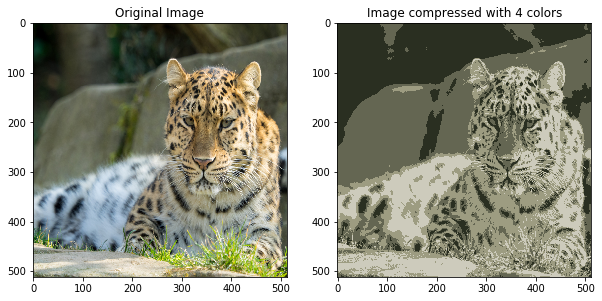

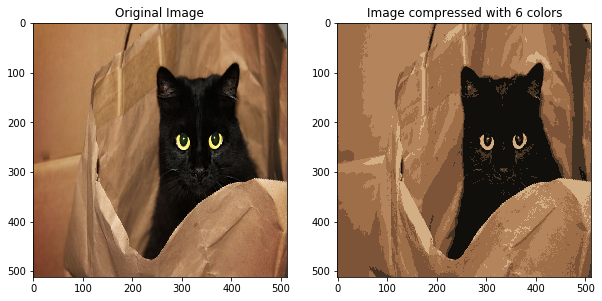

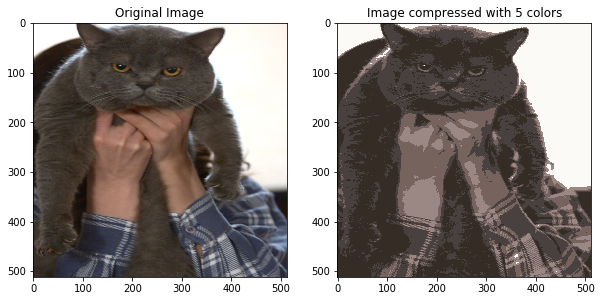

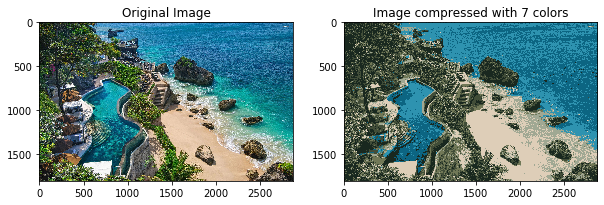

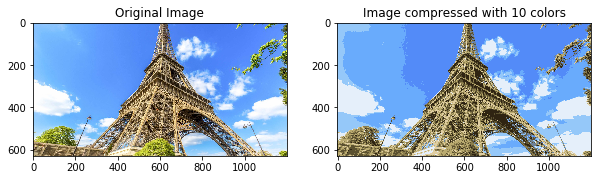

In [17]:
Images = [Image.open('Images/small1.png'),
          Image.open('Images/small2.png'),
          Image.open('Images/medium1.png'),
          Image.open('Images/HD1.jpg'),
          Image.open('Images/HD2.jpg'),
         ]     

for img in Images:
    show_images(img, colors=random.randint(3,10))